In [1]:
import pathlib as pl
from pprint import pformat

import flopy
import git
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from flopy.mf6 import MFSimulation
from flopy.plot.styles import styles
from matplotlib.lines import Line2D
from modflow_devtools.misc import get_env, timed

# Example name and workspace paths. If this example is running
# in the git repository, use the folder structure described in
# the README. Otherwise just use the current working directory.
sim_name = "ex-prt-mp7-p01"
# shorten model names so they fit in 16-char limit
gwf_name = sim_name.replace("ex-prt-", "") + "-gwf"
prt_name = sim_name.replace("ex-prt-", "") + "-prt"
mp7_name = sim_name.replace("ex-prt-", "") + "-mp7"
try:
    root = pl.Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None
workspace = root / "examples" if root else pl.Path.cwd()
figs_path = root / "figures" if root else pl.Path.cwd()
sim_ws = workspace / sim_name
gwf_ws = sim_ws / "gwf"
prt_ws = sim_ws / "prt"
mp7_ws = sim_ws / "mp7"
gwf_ws.mkdir(exist_ok=True, parents=True)
prt_ws.mkdir(exist_ok=True, parents=True)
mp7_ws.mkdir(exist_ok=True, parents=True)

# Define output file names
headfile = f"{gwf_name}.hds"
budgetfile = f"{gwf_name}.cbb"
budgetfile_prt = f"{prt_name}.cbb"
trackfile_prt = f"{prt_name}.trk"
trackhdrfile_prt = f"{prt_name}.trk.hdr"
trackcsvfile_prt = f"{prt_name}.trk.csv"

# Settings from environment variables
write = get_env("WRITE", True)
run = get_env("RUN", True)
plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True)
plot_save = get_env("PLOT_SAVE", True)

### Define parameters

Define model units, parameters and other settings.

In [2]:
# Model units
length_units = "feet"
time_units = "days"

# Model parameters
nper = 1  # Number of periods
nlay = 3  # Number of layers
nrow = 21  # Number of rows
ncol = 20  # Number of columns
delr = 500.0  # Column width ($ft$)
delc = 500.0  # Row width ($ft$)
top = 400.0  # Top of the model ($ft$)
botm_str = "220.0, 200.0, 0.0"  # Layer bottom elevations ($ft$)
porosity = 0.1  # Porosity (unitless)
rch = 0.005  # Recharge rate ($ft/d$)
kh_str = "50.0, 0.01, 200.0"  # Horizontal hydraulic conductivity ($ft/d$)
kv_str = "10.0, 0.01, 20.0"  # Vertical hydraulic conductivity ($ft/d$)
wel_q = -150000.0  # Well pumping rate ($ft^3/d$)
riv_h = 320.0  # River stage ($ft$)
riv_z = 317.0  # River bottom ($ft$)
riv_c = 1.0e5  # River conductance ($ft^2/d$)

# Time discretization
nstp = 1
perlen = 1.0
tsmult = 1.0

# Parse bottom elevation and horiz/vert hydraulic cond.
botm = [float(value) for value in botm_str.split(",")]
kh = [float(value) for value in kh_str.split(",")]
kv = [float(value) for value in kv_str.split(",")]

Define data for the MODFLOW 6 well, river, and recharge packages.

In [3]:
# Well package
wel_loc = (2, 10, 9)
wd = [(wel_loc, wel_q)]

# River package
riv_iface = 6
riv_iflowface = -1
rd = []
for i in range(nrow):
    rd.append([(0, i, ncol - 1), riv_h, riv_c, riv_z, riv_iface, riv_iflowface])

# Recharge package
rch_iface = 6
rch_iflowface = -1

Define particle release configurations for the MODPATH 7 model, from which we later generate PRT release configurations.

In [4]:
# Example 1A
mp7_particle_data_1a = flopy.modpath.ParticleData(
    [(0, i, 2) for i in range(nrow)],
    drape=0,
    structured=True,
    particleids=[i for i in range(nrow)],
    localz=1.0,
)

# Example 1B
mp7_particle_data_1b = flopy.modpath.LRCParticleData(
    subdivisiondata=[
        flopy.modpath.FaceDataType(
            drape=0,
            verticaldivisions1=0,
            horizontaldivisions1=0,
            verticaldivisions2=0,
            horizontaldivisions2=0,
            verticaldivisions3=0,
            horizontaldivisions3=0,
            verticaldivisions4=0,
            horizontaldivisions4=0,
            rowdivisions5=0,
            columndivisions5=0,
            rowdivisions6=3,
            columndivisions6=3,
        )
    ],
    lrcregions=[[[0, 0, 0, 0, nrow - 1, ncol - 1]]],
)

Define well and river cell numbers, used to extract and plot model results later.

In [5]:
# Get well and river cell numbers
nodes = {}
k, i, j = wel_loc
nodes["well"] = [ncol * (nrow * k + i) + j]
nodes["river"] = []
for rivspec in rd:
    k, i, j = rivspec[0]
    node = ncol * (nrow * k + i) + j
    nodes["river"].append(node)

### Model setup

Define functions to build models, write input files, and run the simulation.

In [6]:
def build_models(example_name):
    print(f"Building models for {example_name}")

    # Instantiate the MODFLOW 6 GWF simulation object
    gwfsim = flopy.mf6.MFSimulation(
        sim_name=gwf_name, exe_name="mf6", version="mf6", sim_ws=gwf_ws
    )

    # Instantiate the MODFLOW 6 temporal discretization package
    flopy.mf6.modflow.mftdis.ModflowTdis(
        gwfsim,
        pname="tdis",
        time_units="DAYS",
        nper=nper,
        perioddata=[(perlen, nstp, tsmult)],
    )

    # Instantiate the MODFLOW 6 gwf (groundwater-flow) model
    gwf = flopy.mf6.ModflowGwf(
        gwfsim, modelname=gwf_name, model_nam_file=f"{gwf_name}.nam", save_flows=True
    )

    # Instantiate the MODFLOW 6 gwf discretization package
    flopy.mf6.modflow.mfgwfdis.ModflowGwfdis(
        gwf,
        pname="dis",
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        length_units="FEET",
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
    )

    # Instantiate the MODFLOW 6 gwf initial conditions package
    flopy.mf6.modflow.mfgwfic.ModflowGwfic(gwf, pname="ic", strt=top)

    # Instantiate the MODFLOW 6 gwf node property flow package
    flopy.mf6.modflow.mfgwfnpf.ModflowGwfnpf(
        gwf,
        pname="npf",
        icelltype=[1, 0, 0],
        k=kh,
        k33=kv,
        save_saturation=True,
        save_specific_discharge=True,
    )

    # Instantiate the MODFLOW 6 gwf recharge package
    flopy.mf6.modflow.mfgwfrcha.ModflowGwfrcha(
        gwf,
        recharge=rch,
        auxiliary=["iface", "iflowface"],
        aux=[rch_iface, rch_iflowface],
    )

    # Instantiate the MODFLOW 6 gwf well package
    flopy.mf6.modflow.mfgwfwel.ModflowGwfwel(
        gwf, maxbound=1, stress_period_data={0: wd}
    )

    # Instantiate the MODFLOW 6 gwf river package
    flopy.mf6.modflow.mfgwfriv.ModflowGwfriv(
        gwf, auxiliary=["iface", "iflowface"], stress_period_data={0: rd}
    )

    # Instantiate the MODFLOW 6 gwf output control package
    head_record = [headfile]
    budget_record = [budgetfile]
    saverecord = [("HEAD", "ALL"), ("BUDGET", "ALL")]
    flopy.mf6.modflow.mfgwfoc.ModflowGwfoc(
        gwf,
        pname="oc",
        saverecord=saverecord,
        head_filerecord=head_record,
        budget_filerecord=budget_record,
    )

    # Create an iterative model solution (IMS) for the MODFLOW 6 gwf model
    ims = flopy.mf6.ModflowIms(
        gwfsim,
        pname="ims",
        complexity="SIMPLE",
        outer_dvclose=1e-6,
        inner_dvclose=1e-6,
        rcloserecord=1e-6,
    )

    # Instantiate the MODFLOW 6 PRT simulation object
    prtsim = flopy.mf6.MFSimulation(
        sim_name=prt_name, exe_name="mf6", version="mf6", sim_ws=prt_ws
    )

    # Instantiate the MODFLOW 6 temporal discretization package
    flopy.mf6.modflow.mftdis.ModflowTdis(
        prtsim,
        pname="tdis",
        time_units="DAYS",
        nper=nper,
        perioddata=[(perlen, nstp, tsmult)],
    )

    # Instantiate the MODFLOW 6 prt model
    prt = flopy.mf6.ModflowPrt(
        prtsim, modelname=prt_name, model_nam_file=f"{prt_name}.nam"
    )

    # Instantiate the MODFLOW 6 prt discretization package
    flopy.mf6.modflow.mfgwfdis.ModflowGwfdis(
        prt,
        pname="dis",
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        length_units="FEET",
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
    )

    # Instantiate the MODFLOW 6 prt model input package.
    # Assign a different zone number to active cells, well cells, and river cells.
    # This makes it easier to determine where particles terminate.
    izone = np.zeros((nlay, nrow, ncol), dtype=int)
    for l, r, c in gwf.modelgrid.get_lrc(nodes["well"]):
        izone[l, r, c] = 1
    for l, r, c in gwf.modelgrid.get_lrc(nodes["river"]):
        izone[l, r, c] = 2
    flopy.mf6.ModflowPrtmip(prt, pname="mip", porosity=porosity, izone=izone)

    # Instantiate the MODFLOW 6 prt particle release point (prp) package for example 1A,
    # first converting MP7 particle release configurations to PRT format.
    releasepts_1a = list(mp7_particle_data_1a.to_prp(prt.modelgrid))
    flopy.mf6.ModflowPrtprp(
        prt,
        pname="prp1a",
        filename=f"{prt_name}_1a.prp",
        nreleasepts=len(releasepts_1a),
        packagedata=releasepts_1a,
        perioddata={0: ["FIRST"]},
        exit_solve_tolerance=1e-5,
        extend_tracking=True,
    )

    # Instantiate the MODFLOW 6 prt particle release point (prp) package for example 1B,
    # first converting MP7 particle release configurations to PRT format.
    releasepts_1b = list(mp7_particle_data_1b.to_prp(prt.modelgrid))
    flopy.mf6.ModflowPrtprp(
        prt,
        pname="prp1b",
        filename=f"{prt_name}_1b.prp",
        nreleasepts=len(releasepts_1b),
        packagedata=releasepts_1b,
        perioddata={0: ["FIRST"]},
        exit_solve_tolerance=1e-10,
        extend_tracking=True,
    )

    # Instantiate the MODFLOW 6 prt output control package
    budget_record = [budgetfile_prt]
    track_record = [trackfile_prt]
    trackcsv_record = [trackcsvfile_prt]
    tracktimes = list(range(0, 72000, 1000))
    flopy.mf6.ModflowPrtoc(
        prt,
        pname="oc",
        budget_filerecord=budget_record,
        track_filerecord=track_record,
        trackcsv_filerecord=trackcsv_record,
        ntracktimes=len(tracktimes),
        tracktimes=[(t,) for t in tracktimes],
        saverecord=[("BUDGET", "ALL")],
    )

    # Instantiate the MODFLOW 6 prt flow model interface
    pd = [
        ("GWFHEAD", pl.Path(f"../{gwf_ws.name}/{headfile}")),
        ("GWFBUDGET", pl.Path(f"../{gwf_ws.name}/{budgetfile}")),
    ]
    flopy.mf6.ModflowPrtfmi(prt, packagedata=pd)

    # Create an explicit model solution (EMS) for the MODFLOW 6 prt model
    ems = flopy.mf6.ModflowEms(
        prtsim,
        pname="ems",
        filename=f"{prt_name}.ems",
    )
    prtsim.register_solution_package(ems, [prt.name])

    # Instantiate the MODPATH 7 object
    mp7 = flopy.modpath.Modpath7(
        modelname=mp7_name,
        flowmodel=gwf,
        exe_name="mp7",
        model_ws=mp7_ws,
        budgetfilename=budgetfile,
        headfilename=headfile,
    )

    # Instantiate the MODPATH 7 basic data
    flopy.modpath.Modpath7Bas(mp7, porosity=porosity, defaultiface={"RCH": 6, "EVT": 6})

    # Instantiate the MODPATH 7 particle groups
    pg1a = flopy.modpath.ParticleGroup(
        particlegroupname="PG1A",
        particledata=mp7_particle_data_1a,
        filename=sim_name + "a.sloc",
    )
    pg1b = flopy.modpath.ParticleGroupLRCTemplate(
        particlegroupname="PG1B",
        particledata=mp7_particle_data_1b,
        filename=sim_name + "b.sloc",
    )

    # Instantiate the MODPATH 7 simulation
    mpsim = flopy.modpath.Modpath7Sim(
        mp7,
        simulationtype="combined",
        trackingdirection="forward",
        weaksinkoption="pass_through",
        weaksourceoption="pass_through",
        budgetoutputoption="summary",
        referencetime=[0, 0, 0.0],
        stoptimeoption="extend",
        timepointdata=[500, 1000.0],
        zonedataoption="on",
        zones=izone,
        particlegroups=[pg1a, pg1b],
    )

    return gwfsim, prtsim, mp7


def write_models(*sims, silent=False):
    for sim in sims:
        if isinstance(sim, MFSimulation):
            sim.write_simulation(silent=silent)
        else:
            sim.write_input()


@timed
def run_models(*sims, silent=False):
    for sim in sims:
        if isinstance(sim, MFSimulation):
            success, buff = sim.run_simulation(silent=silent, report=True)
        else:
            success, buff = sim.run_model(silent=silent, report=True)
        assert success, pformat(buff)

Define a function to load pathline data from MODFLOW 6 PRT and MODPATH 7 pathline files.

In [7]:


def get_pathlines(mf6_path, mp7_path):
    # load mf6 pathlines
    mf6pl = pd.read_csv(mf6_path)

    # index by particle group and particle ID
    mf6pl.set_index(["iprp", "irpt"], drop=False, inplace=True)

    # add column mapping particle group to subproblem name (1: A, 2: B)
    mf6pl["subprob"] = mf6pl.apply(lambda row: "A" if row.iprp == 1 else "B", axis=1)

    # add release time and termination time columns
    mf6pl["t0"] = (
        mf6pl.groupby(level=["iprp", "irpt"])
        .apply(lambda x: x.t.min())
        .to_frame(name="t0")
        .t0
    )
    mf6pl["tt"] = (
        mf6pl.groupby(level=["iprp", "irpt"])
        .apply(lambda x: x.t.max())
        .to_frame(name="tt")
        .tt
    )

    # determine which particles ended up in which capture zone
    mf6pl["destzone"] = mf6pl[mf6pl.istatus > 1].izone
    mf6pl["dest"] = mf6pl.apply(
        lambda row: (
            "well" if row.destzone == 1 else "river" if row.destzone == 2 else pd.NA
        ),
        axis=1,
    )

    # add markercolor column, color-coding by layer for plots
    mf6pl["mc"] = mf6pl.apply(
        lambda row: "green" if row.ilay == 1 else "gold" if row.ilay == 2 else "red",
        axis=1,
    )

    # load mp7 pathlines, letting flopy determine capture areas
    mp7plf = flopy.utils.PathlineFile(mp7_path)
    mp7pl_wel = pd.DataFrame(
        mp7plf.get_destination_pathline_data(nodes["well"], to_recarray=True)
    )
    mp7pl_wel["destzone"] = 1
    mp7pl_wel["dest"] = "well"
    mp7pl_riv = pd.DataFrame(
        mp7plf.get_destination_pathline_data(nodes["river"], to_recarray=True)
    )
    mp7pl_riv["destzone"] = 2
    mp7pl_riv["dest"] = "river"
    mp7pl = pd.concat([mp7pl_wel, mp7pl_riv])

    # index by particle group and particle ID
    mp7pl.set_index(["particlegroup", "sequencenumber"], drop=False, inplace=True)

    # convert indices to 1-based (flopy converts them to 0-based, but PRT uses 1-based, so do the same for consistency)
    kijnames = [
        "k",
        "node",
        "particleid",
        "particlegroup",
        "particleidloc",
        "sequencenumber",
    ]

    for n in kijnames:
        mp7pl[n] += 1

    # add column mapping particle group to subproblem name (1: A, 2: B)
    mp7pl["subprob"] = mp7pl.apply(
        lambda row: (
            "A" if row.particlegroup == 1 else "B" if row.particlegroup == 2 else pd.NA
        ),
        axis=1,
    )

    # add release time and termination time columns
    mp7pl["t0"] = (
        mp7pl.groupby(level=["particlegroup", "sequencenumber"])
        .apply(lambda x: x.time.min())
        .to_frame(name="t0")
        .t0
    )
    mp7pl["tt"] = (
        mp7pl.groupby(level=["particlegroup", "sequencenumber"])
        .apply(lambda x: x.time.max())
        .to_frame(name="tt")
        .tt
    )

    # add markercolor column, color-coding by layer for plots
    mp7pl["mc"] = mp7pl.apply(
        lambda row: "green" if row.k == 1 else "gold" if row.k == 2 else "red", axis=1
    )

    return mf6pl, mp7pl

### Plotting results

Define functions to plot model results.

In [8]:
# Pathline and starting point colors by destination
colordest = {"well": "red", "river": "blue"}


def plot_pathlines(ax, gwf, data, mc_map=None, **kwargs):
    ax.set_aspect("equal")
    pl = flopy.plot.PlotMapView(model=gwf, ax=ax)
    pl.plot_grid(lw=0.5, alpha=0.5)

    for dest in ["well", "river"]:
        label = None
        if "colordest" in kwargs:
            color = kwargs["colordest"][dest]
            label = "Captured by " + dest
        elif "color" in kwargs:
            color = kwargs["color"]
        else:
            color = "blue"
        d = data[data.dest == dest]
        if mc_map:
            for k in [1, 2, 3]:
                pl.plot_pathline(
                    d[d.ireason != 1],
                    colors=[color],
                    layer=k,
                    label=label,
                    linewidth=0.0,
                    linestyle="None",
                    marker="o",
                    markercolor=mc_map[k],
                    markersize=3,
                    alpha=0.5,
                )
        pl.plot_pathline(
            d, layer="all", colors=[color], label=label, linewidth=0.5, alpha=0.5
        )


def plot_points(ax, gwf, data, **kwargs):
    ax.set_aspect("equal")
    mm = flopy.plot.PlotMapView(model=gwf, ax=ax)
    mm.plot_grid(lw=0.5, alpha=0.5)
    if "colordest" in kwargs:
        pts = []
        for dest in ["well", "river"]:
            color = kwargs["colordest"][dest]
            label = "Captured by " + dest
            pdata = data[data.dest == dest]
            pts.append(
                ax.scatter(pdata["x"], pdata["y"], s=3, color=color, label=label)
            )
        return pts
    else:
        return ax.scatter(data["x"], data["y"], s=1, c=data["tt"])


def plot_head(gwf, head):
    with styles.USGSPlot():
        fig, ax = plt.subplots(figsize=(7, 7))
        fig.tight_layout()
        ax.set_aspect("equal")
        ilay = 2
        cint = 0.25
        hmin = head[ilay, 0, :].min()
        hmax = head[ilay, 0, :].max()
        styles.heading(ax=ax, heading=f"Head, layer {ilay + 1!s}")
        mm = flopy.plot.PlotMapView(gwf, ax=ax, layer=ilay)
        mm.plot_grid(lw=0.5)
        mm.plot_bc("WEL", plotAll=True)
        mm.plot_bc("RIV", plotAll=True)

        pc = mm.plot_array(head[ilay, :, :], edgecolor="black", alpha=0.25)
        cb = plt.colorbar(pc, shrink=0.25, pad=0.1)
        cb.ax.set_xlabel(r"Head ($m$)")

        levels = np.arange(np.floor(hmin), np.ceil(hmax) + cint, cint)
        cs = mm.contour_array(head[ilay, :, :], colors="white", levels=levels)
        plt.clabel(cs, fmt="%.1f", colors="white", fontsize=11)

        ax.legend(
            handles=[
                mpl.patches.Patch(color="red", label="Well"),
                mpl.patches.Patch(color="teal", label="River"),
            ],
            loc="upper left",
        )

        if plot_show:
            plt.show()
        if plot_save:
            fig.savefig(figs_path / f"{sim_name}-head")


def plot_pathpoints(gwf, mf6pl, title=None):
    with styles.USGSPlot():
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
        if title is not None:
            styles.heading(ax, heading=title)

        mc_map = {1: "green", 2: "gold", 3: "red"}
        plot_pathlines(ax, gwf, mf6pl, mc_map=mc_map)

        ax.legend(
            title="EXPLANATION",
            handles=[
                Line2D(
                    [0],
                    [0],
                    marker="o",
                    markersize=10,
                    markerfacecolor="green",
                    color="w",
                    lw=4,
                    label="Layer 1",
                ),
                Line2D(
                    [0],
                    [0],
                    marker="o",
                    markersize=10,
                    markerfacecolor="gold",
                    color="w",
                    lw=4,
                    label="Layer 2",
                ),
                Line2D(
                    [0],
                    [0],
                    marker="o",
                    markersize=10,
                    markerfacecolor="red",
                    color="w",
                    lw=4,
                    label="Layer 3",
                ),
            ],
        )

        if plot_show:
            plt.show()
        if plot_save:
            fig.savefig(figs_path / f"{sim_name}-paths-layer.png")


def plot_pathpoints_3d(gwf, pathlines, title):
    import pyvista as pv
    from flopy.export.vtk import Vtk

    pv.set_plot_theme("document")
    axes = pv.Axes(show_actor=False, actor_scale=2.0, line_width=5)
    vert_exag = 10
    vtk = Vtk(model=gwf, binary=False, vertical_exageration=vert_exag, smooth=True)
    vtk.add_model(gwf)
    vtk.add_pathline_points(pathlines)
    gwf_mesh, prt_mesh = vtk.to_pyvista()
    riv_mesh = pv.Box(
        bounds=[
            gwf.modelgrid.extent[1] - delc,
            gwf.modelgrid.extent[1],
            gwf.modelgrid.extent[2],
            gwf.modelgrid.extent[3],
            220 * vert_exag,
            gwf.output.head().get_data()[(0, 0, ncol - 1)] * vert_exag,
        ]
    )
    wel_mesh = pv.Box(bounds=(4500, 5000, 5000, 5500, 0, 200 * vert_exag))
    bed_mesh = pv.Box(
        bounds=[
            gwf.modelgrid.extent[0],
            gwf.modelgrid.extent[1],
            gwf.modelgrid.extent[2],
            gwf.modelgrid.extent[3],
            200 * vert_exag,
            220 * vert_exag,
        ]
    )
    gwf_mesh.rotate_z(100, point=axes.origin, inplace=True)
    gwf_mesh.rotate_y(-20, point=axes.origin, inplace=True)
    gwf_mesh.rotate_x(20, point=axes.origin, inplace=True)
    prt_mesh.rotate_z(100, point=axes.origin, inplace=True)
    prt_mesh.rotate_y(-20, point=axes.origin, inplace=True)
    prt_mesh.rotate_x(20, point=axes.origin, inplace=True)
    riv_mesh.rotate_z(100, point=axes.origin, inplace=True)
    riv_mesh.rotate_y(-20, point=axes.origin, inplace=True)
    riv_mesh.rotate_x(20, point=axes.origin, inplace=True)
    wel_mesh.rotate_z(100, point=axes.origin, inplace=True)
    wel_mesh.rotate_y(-20, point=axes.origin, inplace=True)
    wel_mesh.rotate_x(20, point=axes.origin, inplace=True)
    bed_mesh.rotate_z(100, point=axes.origin, inplace=True)
    bed_mesh.rotate_y(-20, point=axes.origin, inplace=True)
    bed_mesh.rotate_x(20, point=axes.origin, inplace=True)

    def _plot(screenshot=False):
        p = pv.Plotter(
            window_size=[500, 500],
            off_screen=screenshot,
            notebook=False if screenshot else None,
        )
        p.enable_anti_aliasing()
        p.add_title(title, font_size=7)
        p.add_mesh(gwf_mesh, opacity=0.025, style="wireframe")
        p.add_mesh(
            prt_mesh,
            scalars="k" if "k" in prt_mesh.point_data else "ilay",
            cmap=["green", "gold", "red"],
            point_size=4,
            line_width=3,
            render_points_as_spheres=True,
            render_lines_as_tubes=True,
            smooth_shading=True,
        )
        p.add_mesh(riv_mesh, color="teal", opacity=0.2)
        p.add_mesh(wel_mesh, color="red", opacity=0.3)
        p.add_mesh(bed_mesh, color="tan", opacity=0.1)
        p.remove_scalar_bar()
        p.add_legend(
            labels=[("Layer 1", "green"), ("Layer 2", "gold"), ("Layer 3", "red")],
            bcolor="white",
            face="r",
            size=(0.15, 0.15),
        )

        p.camera.zoom(1.7)
        p.show()
        if screenshot:
            p.screenshot(figs_path / f"{sim_name}-paths-3d.png")

    if plot_show:
        _plot()
    if plot_save:
        _plot(screenshot=True)


def plot_all_pathlines(gwf, mf6pl, title=None):
    with styles.USGSPlot():
        fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(7, 7))
        if title is not None:
            styles.heading(axes[0], heading=title)

        plot_pathlines(axes[0], gwf, mf6pl[mf6pl.subprob == "A"], colordest=colordest)
        plot_pathlines(axes[1], gwf, mf6pl[mf6pl.subprob == "B"], colordest=colordest)

        axes[0].set_xlabel("1A")
        axes[1].set_xlabel("1B")
        axes[0].legend(
            handles=[
                Line2D([0], [0], color="red", lw=1, label="Well"),
                Line2D([0], [0], color="blue", lw=1, label="River"),
            ],
        )

        if plot_show:
            plt.show()
        if plot_save:
            fig.savefig(figs_path / f"{sim_name}-paths.png")


def plot_all_release_pts(gwf, mf6pl, title=None, color="destination"):
    with styles.USGSPlot():
        fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(7, 7))
        if title is not None:
            styles.heading(axes[0], heading=title)

        mf6sp = mf6pl[mf6pl.ireason == 0]  # release event
        kwargs = {}
        if color == "destination":
            kwargs["colordest"] = colordest

        plot_points(axes[0], gwf, mf6sp[mf6sp.subprob == "A"], **kwargs)
        pts = plot_points(axes[1], gwf, mf6sp[mf6sp.subprob == "B"], **kwargs)

        axes[0].set_xlabel("1A")
        axes[1].set_xlabel("1B")

        if color == "destination":
            axes[0].legend(
                handles=[
                    Line2D(
                        [0],
                        [0],
                        color="red",
                        marker="o",
                        markerfacecolor="red",
                        markersize=5,
                        lw=0,
                        label="Well",
                    ),
                    Line2D(
                        [0],
                        [0],
                        color="blue",
                        marker="o",
                        markerfacecolor="blue",
                        markersize=5,
                        lw=0,
                        label="River",
                    ),
                ],
            )
        else:
            cax = fig.add_axes([0.2, 0.2, 0.6, 0.01])
            cb = plt.colorbar(pts, cax=cax, orientation="horizontal", shrink=0.25)
            cb.set_label("Travel time (days)")

        if plot_show:
            plt.show()
        if plot_save:
            fig.savefig(figs_path / f"{sim_name}-rel-{color}.png")


def plot_all_discharge_pts(gwf, mf6pl, title=None, color="destination"):
    mf6ep = mf6pl[mf6pl.ireason == 3]  # termination event

    with styles.USGSPlot():
        fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(7, 7))
        if title is not None:
            styles.heading(axes[0], heading=title)

        kwargs = {}
        if color == "destination":
            kwargs["colordest"] = colordest

        plot_points(axes[0], gwf, mf6ep[mf6ep.subprob == "A"], **kwargs)
        pts = plot_points(axes[1], gwf, mf6ep[mf6ep.subprob == "B"], **kwargs)

        axes[0].set_xlabel("1A")
        axes[1].set_xlabel("1B")

        if color == "destination":
            axes[0].legend(
                handles=[
                    Line2D(
                        [0],
                        [0],
                        color="red",
                        marker="o",
                        markerfacecolor="red",
                        markersize=5,
                        lw=0,
                        label="Well",
                    ),
                    Line2D(
                        [0],
                        [0],
                        color="blue",
                        marker="o",
                        markerfacecolor="blue",
                        markersize=5,
                        lw=0,
                        label="River",
                    ),
                ],
            )
        else:
            cax = fig.add_axes([0.2, 0.2, 0.6, 0.01])
            cb = plt.colorbar(pts, cax=cax, orientation="horizontal", shrink=0.25)
            cb.set_label("Travel time")

        if plot_show:
            plt.show()
        if plot_save:
            fig.savefig(figs_path / f"{sim_name}-term-{color}.png")


def load_head():
    head_file = flopy.utils.HeadFile(gwf_ws / (gwf_name + ".hds"))
    return head_file.get_data()


def plot_all(gwfsim):
    # get gwf model
    gwf = gwfsim.get_model(gwf_name)
    head = load_head()

    # get pathlines
    mf6pathlines, mp7pathlines = get_pathlines(
        prt_ws / trackcsvfile_prt,
        mp7_ws / f"{mp7_name}.mppth",
    )

    # plot the results
    plot_head(gwf, head=head)
    plot_pathpoints(
        gwf,
        mf6pathlines[mf6pathlines.iprp == 1],
        title="Pathlines and points (1A), colored by layer",
    )
    plot_pathpoints_3d(
        gwf,
        mf6pathlines[mf6pathlines.iprp == 1],
        title="Pathlines and points (1A),\ncolored by layer, 3D view",
    )
    plot_all_pathlines(gwf, mf6pathlines, title="Pathlines, colored by destination")
    plot_all_release_pts(
        gwf,
        mf6pathlines,
        title="Release points, colored by destination",
        color="destination",
    )
    plot_all_discharge_pts(
        gwf,
        mf6pathlines,
        title="Terminating points, colored by destination",
        color="destination",
    )
    plot_all_release_pts(
        gwf,
        mf6pathlines,
        title="Release points, colored by travel-time",
        color="travel-time",
    )

### Running the example

Define a function to run the example scenarios and plot results.

In [9]:
def scenario(silent=False):
    gwfsim, prtsim, mp7 = build_models(sim_name)
    if write:
        write_models(gwfsim, prtsim, mp7, silent=silent)
    if run:
        run_models(gwfsim, prtsim, mp7, silent=silent)
    if plot:
        plot_all(gwfsim)

Building models for ex-prt-mp7-p01
run_models took 4146.94 ms


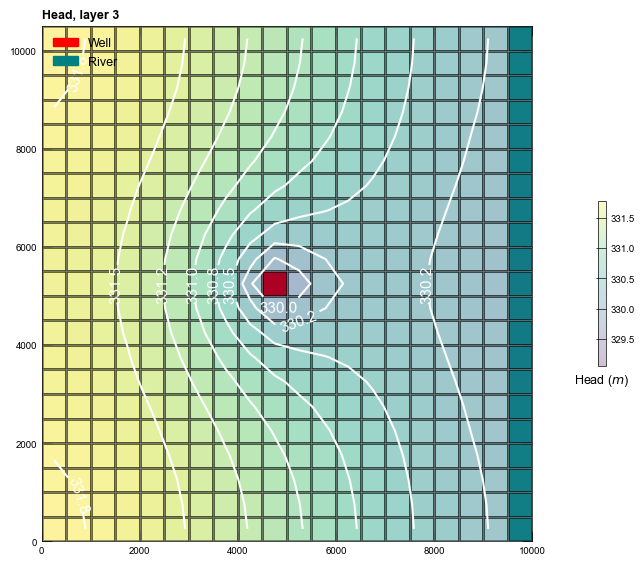

C:\Users\gross.DESKTOP-AIRQM2M\anaconda3\Lib\site-packages\executing\executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
C:\Users\gross.DESKTOP-AIRQM2M\anaconda3\Lib\site-packages\executing\executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
C:\Users\gross.DESKTOP-AIRQM2M\anaconda3\Lib\ast.py:587: DeprecationWarning: Attribute s is deprecated and will be removed in Python 3.14; use value instead
  return Constant(*args, **kwargs)
C:\Users\gross.DESKTOP-AIRQM2M\anaconda3\Lib\site-packages\executing\executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
C:\Users\gross.DESKTOP-AIRQM2M\anaconda3\Lib\ast.py:587: DeprecationWarning: Attribute s is deprecated and will be removed in Python 3.14; use value in

FileNotFoundError: [Errno 2] No such file or directory: 'E:\\15_REPOS\\00_BETAMI\\figures\\ex-prt-mp7-p01-head.png'

In [10]:
# We are now ready to run the example problem. Subproblems 1A and 1B are solved by a single MODFLOW 6 run and a single MODPATH 7 run, so they are included under one "scenario". Each of the two subproblems is represented by its own particle release package (for MODFLOW 6) or particle group (for MODPATH 7).
scenario(silent=True)